# Testing
### Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Religion und Jahr, seit 1934.

Datum: 15.03.2022


### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [15]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
#import leafmap

import requests
import io


In [16]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [17]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [18]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [19]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [20]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 11 datenstand:  9 time.struct_time(tm_year=2022, tm_mon=11, tm_mday=10, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=314, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [21]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [22]:
package_name = "bev_bestand_jahr_konfession_od3160"

In [23]:
dataset_name = "BEV316OD3160.csv"

**Statische Pfade in DWH-Dropzones**

In [24]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [25]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [26]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [27]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [28]:
from IPython.display import Markdown as md

In [29]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_konfession_od3160 

In [30]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_konfession_od3160 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [31]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [32]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_konfession_od3160/download/BEV316OD3160.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [33]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

ValueError: Missing column provided to 'parse_dates': 'StichtagDatJahr'

Berechne weitere Attribute falls notwendig

In [23]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        Jahr = lambda x: x.StichtagDatJahr,
        Jahr_str = lambda x: x.Jahr.astype(str),
    )
    .sort_values('Jahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr    datetime64[ns]
KonOGDSort                  int64
KonOGDKurz                 object
AnzBestWir                  int64
Jahr               datetime64[ns]
Jahr_str                   object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [24]:
#data2betested.head(6)

In [25]:
data2betested.dtypes

StichtagDatJahr    datetime64[ns]
KonOGDSort                  int64
KonOGDKurz                 object
AnzBestWir                  int64
Jahr               datetime64[ns]
Jahr_str                   object
dtype: object

In [26]:
data2betested.shape

(264, 6)

Beschreibe einzelne Attribute

In [27]:
data2betested.describe()

,KonOGDSort,AnzBestWir
count,264,264
mean,2,128033
std,1,70953
min,1,13634
25%,1,91481
50%,2,123694
75%,4,163631
max,4,266818


Wie viele Nullwerte gibt es im Datensatz?

In [28]:
data2betested.isnull().sum()

StichtagDatJahr    0
KonOGDSort         0
KonOGDKurz         0
AnzBestWir         0
Jahr               0
Jahr_str           0
dtype: int64

Welches sind die Quartiere ohne Werte bei AnzBestWir?

In [29]:
data2betested[np.isnan(data2betested.AnzBestWir)]

,StichtagDatJahr,KonOGDSort,KonOGDKurz,AnzBestWir,Jahr,Jahr_str


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [30]:
data2betested = data2betested.set_index("Jahr")

In [31]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2021-01-01 to 1934-01-01
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   StichtagDatJahr  264 non-null    datetime64[ns]
 1   KonOGDSort       264 non-null    int64         
 2   KonOGDKurz       264 non-null    object        
 3   AnzBestWir       264 non-null    int64         
 4   Jahr_str         264 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 12.4+ KB


Int64Index([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
            2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994,
            1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980,
            1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966,
            1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952,
            1951, 1950, 1949, 1948, 1947, 1946, 1945, 1944, 1943, 1942, 1941, 1940, 1939, 1938,
            1937, 1936, 1935, 1934],
           dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [32]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [33]:
data2betested.loc["2020"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,StichtagDatJahr,KonOGDSort,KonOGDKurz,AnzBestWir,Jahr_str
Jahr,,,,,
2020-01-01,2020-01-01,4,andere Konf.,244989,2020-01-01
2020-01-01,2020-01-01,1,EV-REF,81727,2020-01-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Bildungsstand

In [34]:
data2betested.columns

Index(['StichtagDatJahr', 'KonOGDSort', 'KonOGDKurz', 'AnzBestWir', 'Jahr_str'], dtype='object')

In [36]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1930":"2020"]\
    .groupby(['Jahr', 'Jahr_str', 'KonOGDSort', 'KonOGDKurz']) \
    .agg(sum_AnzBestWir=('AnzBestWir', 'mean')) \
    .sort_values('Jahr', ascending=True) 

myAgg.reset_index().head(3)

,Jahr,Jahr_str,KonOGDSort,KonOGDKurz,sum_AnzBestWir
0,1934-01-01,1934-01-01,1,EV-REF,208357
1,1934-01-01,1934-01-01,2,RK,92740
2,1934-01-01,1934-01-01,4,andere Konf.,14767


In [44]:
myTitle="Anteil der Wohnbevölkerung nach Religion seit 1850"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['KonOGDKurz'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_AnzBestWir>0'), title=myTitle).encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzBestWir', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('KonOGDKurz', legend=alt.Legend(title="Konfession (gruppiert)", orient="right"))  
    ,tooltip=['Jahr_str', 'KonOGDKurz','sum_AnzBestWir']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [45]:
data2betested.columns

Index(['StichtagDatJahr', 'KonOGDSort', 'KonOGDKurz', 'AnzBestWir', 'Jahr_str'], dtype='object')

In [46]:
myAgg.head()

sum_AnzBestWir
Jahr       Jahr_str   KonOGDSort KonOGDKurz                  
1934-01-01 1934-01-01 1          EV-REF                208357
                      2          RK                     92740
                      4          andere Konf.           14767
1935-01-01 1935-01-01 1          EV-REF                209469
                      2          RK                     93184

In [47]:
#help(sns.catplot)     

In [43]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

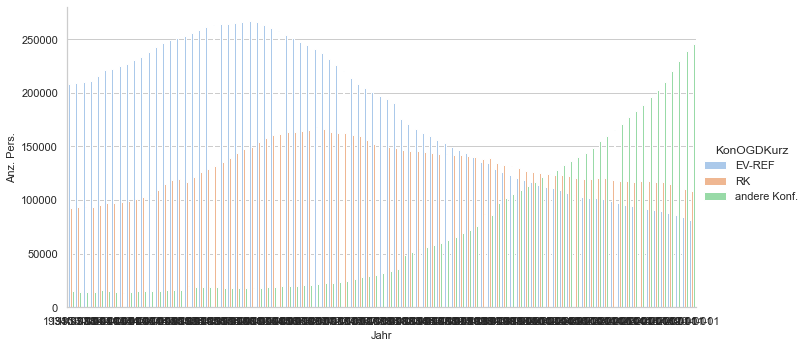

In [51]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr_str"
            , y="sum_AnzBestWir"
            , hue="KonOGDKurz"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAgg.loc["1934":"2020"].reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [52]:
data2betested.columns

Index(['StichtagDatJahr', 'KonOGDSort', 'KonOGDKurz', 'AnzBestWir', 'Jahr_str'], dtype='object')

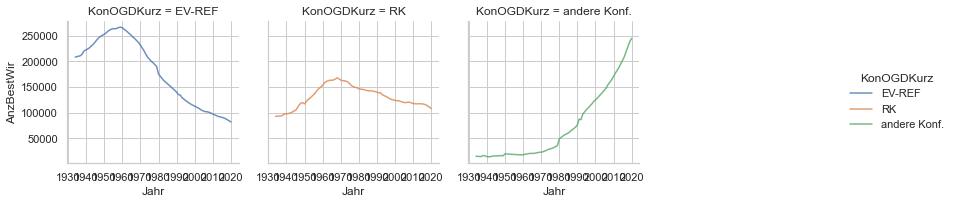

In [54]:
g2 = sns.FacetGrid(data2betested.loc["1934":"2020"].sort_values('KonOGDSort',ascending=True).reset_index(), col="KonOGDKurz", hue="KonOGDKurz", col_wrap=4, height=3,)
g2.map(sns.lineplot, "Jahr","AnzBestWir",alpha=.8)
g2.add_legend()


## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=52&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------